In [ ]:
#dependencias
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import os

import torch.nn as nn
import torch.nn.functional as F
import math

import torch.optim as optim
from tqdm import tqdm

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
class TSPDataset(Dataset):
    def __init__(self, data_dir, phase='Easy', limit_files=None):
        super().__init__()
        
        # Búsqueda de archivos
        search_path = os.path.join(data_dir, phase, '*.npz')
        self.file_paths = glob.glob(search_path)
        
        if not self.file_paths:
            # Intento alternativo (Validation/Easy vs Easy)
            search_path = os.path.join(data_dir, phase.capitalize(), '*.npz')
            self.file_paths = glob.glob(search_path)

        if not self.file_paths:
            print(f"⚠️ ADVERTENCIA: No se encontraron archivos en {search_path}")
            # Esto evita que explote si una carpeta está vacía, pero devolverá dataset vacío
            self.data_points = torch.empty(0)
            self.data_solutions = torch.empty(0)
            return
            
        if limit_files:
            self.file_paths = self.file_paths[:limit_files]
            
        print(f"🔄 {phase}: Procesando {len(self.file_paths)} archivos...")
        
        self.points_list = []
        self.solutions_list = []
        
        for fp in self.file_paths:
            try:
                data = np.load(fp, allow_pickle=True) 
                pts = data['points']
                sols = data['solutions']
                
                # --- CORRECCIÓN CRÍTICA DE TIPO ---
                # Si sols es tipo 'object', lo forzamos a int64
                if sols.dtype == object:
                    # Usamos .tolist() para desempaquetar y reconstruir como array numérico limpio
                    sols = np.array(sols.tolist(), dtype=np.int64)
                
                # Asegurarse de que sea int64 (Long) estándar
                sols = sols.astype(np.int64)
                
                # Normalización defensiva para los puntos
                if pts.max() > 1.0 + 1e-5:
                    pts = pts / pts.max()
                
                self.points_list.append(pts)
                self.solutions_list.append(sols)
            except Exception as e:
                print(f"⚠️ Saltando archivo corrupto {os.path.basename(fp)}: {e}")

        # Concatenar
        if len(self.points_list) > 0:
            # Convertimos las listas de numpy arrays a un solo numpy array gigante primero
            all_pts = np.concatenate(self.points_list, axis=0)
            all_sols = np.concatenate(self.solutions_list, axis=0)
            
            # Y finalmente a Tensores
            self.data_points = torch.FloatTensor(all_pts)
            self.data_solutions = torch.LongTensor(all_sols)
            
            print(f"✅ {phase} LISTO. Shape: {self.data_points.size()}")
        else:
            print("⚠️ Dataset vacío.")

    def __len__(self):
        # Corrección para evitar error si el dataset está vacío
        if not hasattr(self, 'data_points'): return 0
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx], self.data_solutions[idx]

In [ ]:
#Encoder
class GraphAttentionEncoder(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_layers=3):
        super().__init__()
        
        # 1. Proyección Inicial: Coordenada (2) -> Embedding (128)
        # Usamos 1x1 Conv como una capa lineal compartida para todos los nodos
        self.init_embed = nn.Linear(input_dim, embed_dim)
        
        # 2. Bloques de Atención (Transformer Encoder sin Positional Encoding)
        # Usamos Pre-Normalization (norm antes de attention) que es más estable
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim, 
                nhead=num_heads, 
                dim_feedforward=512, 
                dropout=0.1, 
                activation="relu",
                batch_first=True,   # Importante: [Batch, Seq, Feature]
                norm_first=True     # Pre-LN
            )
            for _ in range(num_layers)
        ])
        
    def forward(self, x):
        """
        x: [Batch, Num_Cities, 2]
        Returns: 
           embeddings: [Batch, Num_Cities, Embed_Dim]
           graph_embedding: [Batch, Embed_Dim] (Vector resumen del mapa)
        """
        h = self.init_embed(x) # [B, N, 128]
        
        for layer in self.layers:
            h = layer(h)
            
        # Calculamos el vector global del grafo (promedio de todos los nodos)
        # Esto sirve para decirle al Decoder: "Así se ve el mapa completo"
        graph_embedding = h.mean(dim=1) 
        
        return h, graph_embedding

#VERIFICACION
# Vamos a verificar si funciona inmediatamente
if __name__ == "__main__":
    # Simular un batch de 2 mapas con 20 ciudades
    fake_input = torch.rand(2, 20, 2) 
    encoder = GraphAttentionEncoder()
    emb, graph_emb = encoder(fake_input)
    print(f"Encoder Output: {emb.shape}") # Debería ser [2, 20, 128]
    print(f"Graph Context: {graph_emb.shape}") # Debería ser [2, 128]

Encoder Output: torch.Size([2, 20, 128])
Graph Context: torch.Size([2, 128])


In [ ]:
#Decoder
class PointerDecoder(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Mecanismo de Atención Multi-Cabezal estándar de PyTorch
        # batch_first=True espera [Batch, Seq, Features]
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # Un vector "comodín" aprendible para el primer paso (cuando no venimos de ninguna ciudad)
        self.start_placeholder = nn.Parameter(torch.randn(embed_dim))
        
        # Una capa para fusionar (Grafo + Último Nodo) en una sola Query
        self.project_query = nn.Linear(embed_dim * 2, embed_dim)

    def forward(self, last_node_emb, encoder_outputs, graph_emb, visited_mask):
        """
        last_node_emb: [Batch, Embed_Dim] (Embedding de la ciudad actual)
        encoder_outputs: [Batch, N_Cities, Embed_Dim] (Memoria del Encoder)
        graph_emb: [Batch, Embed_Dim] (Resumen del mapa)
        visited_mask: [Batch, N_Cities] (True = Ya visitada/Prohibida)
        """
        batch_size = encoder_outputs.size(0)
        
        # 1. Definir la Query (¿Qué busco ahora?)
        if last_node_emb is None:
            # Paso 0: Usamos el placeholder porque no hemos visitado nada aún
            current_emb = self.start_placeholder.unsqueeze(0).expand(batch_size, -1)
        else:
            current_emb = last_node_emb
            
        # El contexto es: "Cómo es el mapa" + "Dónde estoy"
        context = torch.cat([graph_emb, current_emb], dim=1) # [B, 256]
        query = self.project_query(context).unsqueeze(1)     # [B, 1, 128]
        
        # 2. Atención Cruzada (Cross-Attention)
        # La Query "interroga" a todas las ciudades (Keys/Values)
        # attn_output resume la información de las ciudades más relevantes para este paso
        attn_output, _ = self.mha(query, encoder_outputs, encoder_outputs)
        
        # 3. Mecanismo de Puntero (Calcular Scores)
        # Calculamos la similitud (Producto Punto) entre la salida de atención y CADA ciudad
        # [Batch, 1, 128] x [Batch, 128, N_Cities] = [Batch, 1, N_Cities]
        scores = torch.matmul(attn_output, encoder_outputs.transpose(1, 2)).squeeze(1)
        
        # Escalar para estabilidad (Scale Dot Product)
        scores = scores / math.sqrt(self.embed_dim)
        
        # 4. Enmascaramiento (Bloquear visitados)
        if visited_mask is not None:
            # Ponemos -infinito para que la probabilidad sea 0 tras el Softmax
            scores = scores.masked_fill(visited_mask, float('-inf'))
            
        return scores

In [ ]:
#modelo transformer
class TSPTransformer(nn.Module):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_layers=3):
        super().__init__()
        
        # Instanciamos nuestras piezas
        self.encoder = GraphAttentionEncoder(input_dim, embed_dim, num_heads, num_layers)
        self.decoder = PointerDecoder(embed_dim, num_heads)

    def forward(self, x, target_tour):
        """
        Modo Entrenamiento (Teacher Forcing)
        x: [Batch, N, 2] Coordenadas
        target_tour: [Batch, N] Índices de la ruta óptima (Ground Truth)
        """
        batch_size, num_cities, _ = x.size()
        
        # 1. Codificar el mapa
        encoder_outputs, graph_emb = self.encoder(x)
        
        # 2. Preparar bucle de entrenamiento
        outputs_logits = []
        
        # Máscara inicial (todo False = nada visitado)
        visited_mask = torch.zeros(batch_size, num_cities, dtype=torch.bool, device=x.device)
        
        # Embedding del nodo previo (None al inicio)
        last_node_emb = None
        
        # Bucle sobre la longitud del tour
        for t in range(num_cities):
            # Predecir logits para el paso 't'
            logits = self.decoder(last_node_emb, encoder_outputs, graph_emb, visited_mask)
            outputs_logits.append(logits)
            
            # --- TEACHER FORCING ---
            # Para el siguiente paso, NO usamos lo que predijo el modelo.
            # Usamos la ciudad REAL que debió haber visitado (target_tour)
            true_next_idx = target_tour[:, t]
            
            # Actualizamos máscara con la verdad
            # scatter_ crea una máscara one-hot y la suma
            visited_mask = visited_mask.scatter(1, true_next_idx.unsqueeze(1), True)
            
            # Buscamos el embedding de la ciudad real para el siguiente paso
            # gather: recolecta los embeddings correspondientes a los índices true_next_idx
            # encoder_outputs: [B, N, D] -> gather -> [B, 1, D]
            indices_expanded = true_next_idx.unsqueeze(1).unsqueeze(2).expand(batch_size, 1, 128)
            last_node_emb = encoder_outputs.gather(1, indices_expanded).squeeze(1)

        # Retornamos los logits apilados [Batch, N_Steps, N_Cities]
        return torch.stack(outputs_logits, dim=1)

    def greedy_decode(self, x):
        """
        Modo Inferencia (El modelo construye la ruta solo)
        """
        batch_size, num_cities, _ = x.size()
        
        encoder_outputs, graph_emb = self.encoder(x)
        
        visited_mask = torch.zeros(batch_size, num_cities, dtype=torch.bool, device=x.device)
        last_node_emb = None
        
        tour_indices = []
        
        for _ in range(num_cities):
            # 1. Predecir
            logits = self.decoder(last_node_emb, encoder_outputs, graph_emb, visited_mask)
            
            # 2. Elegir la mejor (Greedy)
            probs = F.softmax(logits, dim=-1)
            next_city_idx = probs.argmax(dim=1) # [Batch]
            
            tour_indices.append(next_city_idx)
            
            # 3. Actualizar estado
            visited_mask = visited_mask.scatter(1, next_city_idx.unsqueeze(1), True)
            
            indices_expanded = next_city_idx.unsqueeze(1).unsqueeze(2).expand(batch_size, 1, 128)
            last_node_emb = encoder_outputs.gather(1, indices_expanded).squeeze(1)
            
        return torch.stack(tour_indices, dim=1)

# PRUEBA FINAL SI FUNCIONA
if __name__ == "__main__":
    model = TSPTransformer()
    
    # Datos falsos
    fake_x = torch.rand(2, 20, 2)       # 2 mapas, 20 ciudades
    fake_y = torch.arange(20).repeat(2, 1) # Ruta dummy 0,1,2...19
    
    # Prueba Forward (Train)
    logits = model(fake_x, fake_y)
    print(f"Logits Train Shape: {logits.shape}") # [2, 20, 20]
    
    # Prueba Greedy (Validación)
    ruta = model.greedy_decode(fake_x)
    print(f"Ruta Generada Shape: {ruta.shape}")  # [2, 20]
    print(f"Ejemplo ruta: {ruta[0]}")

In [ ]:
def calculate_tour_length(node_coords, tour_indices):
    """
    Calcula la distancia Euclideana total de un tour.
    node_coords: [Batch, N, 2]
    tour_indices: [Batch, N]
    """
    batch_size, num_nodes, _ = node_coords.size()
    
    # 1. Reordenar las coordenadas según los índices predichos
    # gather espera índices con dimensiones compatibles, así que expandimos
    # indices: [B, N, 1] expandido a [B, N, 2]
    gathered_coords = node_coords.gather(1, tour_indices.unsqueeze(2).expand(-1, -1, 2))
    
    # 2. Calcular distancia entre ciudad i y ciudad i+1
    # Roll desplaza el tensor para alinear ciudad 0 con ciudad 1, 1 con 2...
    next_coords = torch.roll(gathered_coords, shifts=-1, dims=1)
    
    # Distancia Euclideana
    segment_lengths = torch.norm(gathered_coords - next_coords, p=2, dim=2)
    
    # Sumar todo para obtener largo total del tour
    return segment_lengths.sum(dim=1)

def validate_model(model, val_loader, device):
    model.eval()
    total_gap = 0.0
    count = 0
    
    with torch.no_grad():
        for batch_x, batch_y_opt in val_loader:
            batch_x = batch_x.to(device)
            # batch_y_opt son los índices de la solución óptima (Ground Truth)
            
            # 1. Generar ruta con el modelo (Greedy)
            pred_tour = model.greedy_decode(batch_x)
            
            # 2. Calcular largos
            len_pred = calculate_tour_length(batch_x, pred_tour)
            
            # Recalculamos el largo del óptimo basándonos en los índices guardados
            # (A veces el archivo npz ya trae el largo, pero mejor recalcular para ser consistentes)
            len_opt = calculate_tour_length(batch_x, batch_y_opt.to(device))
            
            # 3. Calcular GAP: (Pred - Opt) / Opt
            # Evitamos división por cero con 1e-6
            gap = (len_pred - len_opt) / (len_opt + 1e-6)
            
            total_gap += gap.sum().item()
            count += batch_x.size(0)
            
    return (total_gap / count) * 100 # Retorna porcentaje

In [31]:
def train_curriculum(model, data_dir, curriculum, device):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    # CAMBIO 1: threshold_mode='abs'. Si el GAP no baja en 0.5% absoluto, reducimos LR.
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, threshold=0.005, verbose=True
    )
    
    criterion = torch.nn.CrossEntropyLoss()
    history = {'loss': [], 'gap': []}

    print(f"🚀 Iniciando entrenamiento GAP-GUIDED en: {device}")
    
    for phase_cfg in curriculum:
        phase_name = phase_cfg['name']
        epochs = phase_cfg['epochs']
        batch_size = phase_cfg['batch_size']
        base_lr = phase_cfg['lr']
        
        # Reset LR
        for param_group in optimizer.param_groups:
            param_group['lr'] = base_lr
            
        print(f"\n=== FASE: {phase_name} ===")
        
        train_ds = TSPDataset(data_dir, phase=phase_name) 
        val_ds = TSPDataset(data_dir, phase=f"Validation/{phase_name}", limit_files=5)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        
        best_gap = float('inf')
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            pbar = tqdm(train_loader, desc=f"Epoca {epoch+1}/{epochs}")
            
            for batch_x, batch_y in pbar:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()
                logits = model(batch_x, batch_y)
                loss = criterion(logits.view(-1, logits.size(-1)), batch_y.view(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            avg_loss = epoch_loss / len(train_loader)
            avg_gap = validate_model(model, val_loader, device)
            
            # CAMBIO 2: El scheduler vigila el GAP
            scheduler.step(avg_gap)
            current_lr = optimizer.param_groups[0]['lr']
            
            history['loss'].append(avg_loss)
            history['gap'].append(avg_gap)
            
            print(f"   📉 Loss: {avg_loss:.4f} | 📏 GAP: {avg_gap:.2f}% | ⚡ LR: {current_lr:.1e}")
            
            if avg_gap < best_gap:
                best_gap = avg_gap
                save_path = f"nuevo_modelo_{phase_name}_best.pth"
                torch.save(model.state_dict(), save_path)
                print(f"   💾 Nuevo récord: {avg_gap:.2f}%")

    return history

In [ ]:
# CONFIGURACIÓN DISPOSITIVO
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = r"C:\Users\Nicolas\OneDrive\Desktop\proyectos\TransformerTSP\Data" # <--- AJUSTA ESTA RUTA SI ES NECESARIO
# Nota: La carpeta Data debe contener dentro: Easy, Medium, Hard, Validation/Easy...

# CURRICULUM LEARNING -> Definimos el plan de estudios
CURRICULUM = [
    {
        'name': 'Easy',
        'epochs': 20,     # Subimos de 10 a 20. Necesita tiempo para afinar.
        'batch_size': 128,
        'lr': 1e-3        # Empezamos fuerte, el Scheduler lo bajará solo.
    },
    {
        'name': 'Medium',
        'epochs': 15,
        'batch_size': 64,
        'lr': 1e-4
    },
    # Descomenta HARD cuando te sientas valiente
    # {
    #    'name': 'Hard',
    #    'epochs': 20,
    #    'batch_size': 32,
    #    'lr': 5e-5
    # }
]

# --- EJECUCIÓN ---
if __name__ == "__main__":
    # 1. Instanciar Modelo
    model = TSPTransformer(embed_dim=128, num_heads=8, num_layers=3).to(DEVICE)
    
    # 2. Entrenar
    # Asegúrate de que DATA_DIR apunta a la carpeta correcta
    historial = train_curriculum(model, DATA_DIR, CURRICULUM, DEVICE)
    
    print("🏁 Entrenamiento Completado.")

#SE DETIENE ANTES EL TRAINING PORQUE EL GAP NO CONVERGE (NO SIGUE APRENDIENDO EL MODELO)

c:\Users\Nicolas\OneDrive\Desktop\proyectos\TransformerTSP\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Iniciando entrenamiento GAP-GUIDED en: cuda

=== FASE: Easy ===
🔄 Easy: Procesando 20 archivos...
✅ Easy LISTO. Shape: torch.Size([10000, 20, 2])
🔄 Validation/Easy: Procesando 5 archivos...
✅ Validation/Easy LISTO. Shape: torch.Size([500, 20, 2])


Epoca 1/20: 100%|██████████| 78/78 [00:07<00:00, 10.72it/s, loss=0.7798]


   📉 Loss: 1.3221 | 📏 GAP: 8.09% | ⚡ LR: 1.0e-03
   💾 Nuevo récord: 8.09%


Epoca 2/20: 100%|██████████| 78/78 [00:06<00:00, 11.22it/s, loss=0.7095]


   📉 Loss: 0.7021 | 📏 GAP: 10.14% | ⚡ LR: 1.0e-03


Epoca 3/20: 100%|██████████| 78/78 [00:06<00:00, 11.56it/s, loss=0.6673]


   📉 Loss: 0.6678 | 📏 GAP: 10.68% | ⚡ LR: 1.0e-03


Epoca 4/20: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s, loss=0.6447]


   📉 Loss: 0.6412 | 📏 GAP: 11.09% | ⚡ LR: 5.0e-04


Epoca 5/20: 100%|██████████| 78/78 [00:06<00:00, 11.41it/s, loss=0.5792]


   📉 Loss: 0.6133 | 📏 GAP: 9.78% | ⚡ LR: 5.0e-04


Epoca 6/20: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s, loss=0.5977]


   📉 Loss: 0.5990 | 📏 GAP: 10.04% | ⚡ LR: 5.0e-04


Epoca 7/20: 100%|██████████| 78/78 [00:06<00:00, 11.62it/s, loss=0.5901]


   📉 Loss: 0.5916 | 📏 GAP: 9.23% | ⚡ LR: 2.5e-04


Epoca 8/20: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s, loss=0.5647]


   📉 Loss: 0.5775 | 📏 GAP: 9.38% | ⚡ LR: 2.5e-04


Epoca 9/20: 100%|██████████| 78/78 [00:06<00:00, 11.69it/s, loss=0.5598]


   📉 Loss: 0.5700 | 📏 GAP: 8.91% | ⚡ LR: 2.5e-04


Epoca 10/20: 100%|██████████| 78/78 [00:06<00:00, 11.51it/s, loss=0.5509]


   📉 Loss: 0.5653 | 📏 GAP: 8.16% | ⚡ LR: 1.3e-04


Epoca 11/20: 100%|██████████| 78/78 [00:06<00:00, 11.29it/s, loss=0.5388]


   📉 Loss: 0.5583 | 📏 GAP: 9.05% | ⚡ LR: 1.3e-04


Epoca 12/20: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s, loss=0.5678]


   📉 Loss: 0.5553 | 📏 GAP: 9.24% | ⚡ LR: 1.3e-04


Epoca 13/20: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s, loss=0.5405]


   📉 Loss: 0.5534 | 📏 GAP: 10.30% | ⚡ LR: 6.3e-05


Epoca 14/20: 100%|██████████| 78/78 [00:06<00:00, 11.26it/s, loss=0.5369]


   📉 Loss: 0.5488 | 📏 GAP: 8.52% | ⚡ LR: 6.3e-05


Epoca 15/20: 100%|██████████| 78/78 [00:06<00:00, 11.58it/s, loss=0.5365]


   📉 Loss: 0.5459 | 📏 GAP: 9.22% | ⚡ LR: 6.3e-05


Epoca 16/20: 100%|██████████| 78/78 [00:06<00:00, 11.45it/s, loss=0.5508]


   📉 Loss: 0.5445 | 📏 GAP: 9.30% | ⚡ LR: 3.1e-05


Epoca 17/20: 100%|██████████| 78/78 [00:06<00:00, 11.35it/s, loss=0.5712]


   📉 Loss: 0.5433 | 📏 GAP: 9.50% | ⚡ LR: 3.1e-05


Epoca 18/20: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s, loss=0.5318]


   📉 Loss: 0.5422 | 📏 GAP: 9.56% | ⚡ LR: 3.1e-05


Epoca 19/20: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s, loss=0.5427]


   📉 Loss: 0.5416 | 📏 GAP: 8.63% | ⚡ LR: 1.6e-05


Epoca 20/20: 100%|██████████| 78/78 [00:06<00:00, 11.49it/s, loss=0.5565]


   📉 Loss: 0.5399 | 📏 GAP: 8.55% | ⚡ LR: 1.6e-05

=== FASE: Medium ===
🔄 Medium: Procesando 20 archivos...
✅ Medium LISTO. Shape: torch.Size([10000, 50, 2])
🔄 Validation/Medium: Procesando 5 archivos...
✅ Validation/Medium LISTO. Shape: torch.Size([500, 50, 2])


Epoca 1/15: 100%|██████████| 156/156 [00:29<00:00,  5.36it/s, loss=0.6765]


   📉 Loss: 0.7065 | 📏 GAP: 15.63% | ⚡ LR: 1.0e-04
   💾 Nuevo récord: 15.63%


Epoca 2/15: 100%|██████████| 156/156 [00:29<00:00,  5.34it/s, loss=0.6730]


   📉 Loss: 0.6828 | 📏 GAP: 15.34% | ⚡ LR: 5.0e-05
   💾 Nuevo récord: 15.34%


Epoca 3/15: 100%|██████████| 156/156 [00:28<00:00,  5.46it/s, loss=0.6677]


   📉 Loss: 0.6729 | 📏 GAP: 17.34% | ⚡ LR: 5.0e-05


Epoca 4/15: 100%|██████████| 156/156 [00:28<00:00,  5.50it/s, loss=0.6572]


   📉 Loss: 0.6678 | 📏 GAP: 17.68% | ⚡ LR: 5.0e-05


Epoca 5/15: 100%|██████████| 156/156 [00:28<00:00,  5.42it/s, loss=0.6672]


   📉 Loss: 0.6641 | 📏 GAP: 17.43% | ⚡ LR: 2.5e-05


Epoca 6/15: 100%|██████████| 156/156 [00:28<00:00,  5.47it/s, loss=0.6742]


   📉 Loss: 0.6601 | 📏 GAP: 17.66% | ⚡ LR: 2.5e-05


Epoca 7/15: 100%|██████████| 156/156 [00:28<00:00,  5.47it/s, loss=0.6502]


   📉 Loss: 0.6587 | 📏 GAP: 17.44% | ⚡ LR: 2.5e-05


Epoca 8/15: 100%|██████████| 156/156 [00:28<00:00,  5.42it/s, loss=0.6659]


   📉 Loss: 0.6571 | 📏 GAP: 17.08% | ⚡ LR: 1.3e-05


Epoca 9/15:  22%|██▏       | 35/156 [00:06<00:23,  5.25it/s, loss=0.6482]


KeyboardInterrupt: 

In [ ]:
#PROYECCIONES TTA PARA VALIDACION DEL MODELO (NO ES TONTO, SI NO QUE LE FALTA OTRA PERSPECTIVA)
def augment_xy_data_by_8_fold(xy_data):
    """
    Genera 8 variaciones simétricas de un lote de mapas TSP.
    xy_data: [Batch, N, 2]
    Retorna: [Batch*8, N, 2]
    """
    # x,y shape: [Batch, N]
    x = xy_data[:,:,0]
    y = xy_data[:,:,1]
    
    # Generamos las 8 transformaciones
    dat1 = torch.stack((x, y), dim=2)
    dat2 = torch.stack((1-x, y), dim=2)
    dat3 = torch.stack((x, 1-y), dim=2)
    dat4 = torch.stack((1-x, 1-y), dim=2)
    dat5 = torch.stack((y, x), dim=2)
    dat6 = torch.stack((1-y, x), dim=2)
    dat7 = torch.stack((y, 1-x), dim=2)
    dat8 = torch.stack((1-y, 1-x), dim=2)
    
    # Unimos todo en un mega-batch
    data_aug = torch.cat((dat1, dat2, dat3, dat4, dat5, dat6, dat7, dat8), dim=0)
    return data_aug

def validate_with_tta(model, val_loader, device):
    model.eval()
    total_gap = 0.0
    count = 0
    
    print("🧪 Iniciando Validación Avanzada (TTA x8)...")
    
    with torch.no_grad():
        for batch_x, batch_y_opt in tqdm(val_loader):
            batch_x = batch_x.to(device)
            batch_size = batch_x.size(0)
            
            # 1. Aumentar datos (8 veces más instancias)
            # Shape pasa de [B, N, 2] -> [B*8, N, 2]
            aug_x = augment_xy_data_by_8_fold(batch_x)
            
            # 2. Predecir Greedy para todas las rotaciones
            # pred_aug: [B*8, N]
            pred_aug = model.greedy_decode(aug_x)
            
            # 3. Calcular largos de rutas
            lengths_aug = calculate_tour_length(aug_x, pred_aug)
            
            # 4. Deshacer el aumento: reformatear a [8, Batch] y tomar el mínimo
            # Queremos la mejor ruta de las 8 variaciones para CADA instancia original
            lengths_aug = lengths_aug.view(8, batch_size)
            best_lengths, _ = lengths_aug.min(dim=0) # [Batch]
            
            # 5. Comparar con el óptimo real
            len_opt = calculate_tour_length(batch_x, batch_y_opt.to(device))
            
            gap = (best_lengths - len_opt) / (len_opt + 1e-6)
            total_gap += gap.sum().item()
            count += batch_size
            
    final_gap = (total_gap / count) * 100
    print(f"🏆 GAP Final con TTA: {final_gap:.2f}%")
    return final_gap

In [ ]:
#EJECUTAR PRUEBA DE VALIDACION CON TTA
# Cargar el mejor modelo guardado
model_path = "nuevo_modelo_Easy_best.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("✅ Modelo cargado.")
    
    # Crear un loader de validación pequeño
    val_ds = TSPDataset(DATA_DIR, phase="Validation/Easy", limit_files=5)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False) # Batch pequeño porque x8 ocupa memoria
    
    validate_with_tta(model, val_loader, DEVICE)
else:
    print("⚠️ No se encontró el archivo del modelo.")

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_28540\222077967.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


✅ Modelo cargado.
🔄 Validation/Easy: Procesando 5 archivos...
✅ Validation/Easy LISTO. Shape: torch.Size([500, 20, 2])
🧪 Iniciando Validación Avanzada (TTA x8)...


100%|██████████| 16/16 [00:00<00:00, 22.56it/s]

🏆 GAP Final con TTA: 2.03%


In [34]:
# --- CONFIGURACIÓN PARA FASE MEDIUM ---

# 1. Definimos solo la fase que nos falta
CURRICULUM_MEDIUM = [
    {
        'name': 'Medium',  # Buscará en Data/Medium
        'epochs': 20,      # Le damos tiempo
        'batch_size': 64,  # Bajamos batch size para que quepa en memoria
        'lr': 1e-4         # LR 10 veces menor para un ajuste fino (Fine-Tuning)
    }
]

# 2. Cargar el "Campeón" de la fase Easy
# Esto es CRÍTICO: Si no cargamos esto, empezaríamos desde cero (bobo).
model_path = "nuevo_modelo_Easy_best.pth"
if os.path.exists(model_path):
    print(f"♻️ Cargando conocimientos previos de: {model_path}")
    # weights_only=False es necesario por ahora hasta que PyTorch cambie el default
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint)
else:
    raise FileNotFoundError("❌ ¡No encuentro el modelo Easy! No entrenes Medium desde cero.")

# 3. Ejecutar Entrenamiento (Usando la función train_curriculum optimizada que ya tienes)
print("\n🔥 INICIANDO FASE 2: MEDIUM (50 CIUDADES) 🔥")
historial_medium = train_curriculum(model, DATA_DIR, CURRICULUM_MEDIUM, DEVICE)

♻️ Cargando conocimientos previos de: nuevo_modelo_Easy_best.pth

🔥 INICIANDO FASE 2: MEDIUM (50 CIUDADES) 🔥
🚀 Iniciando entrenamiento GAP-GUIDED en: cuda

=== FASE: Medium ===
🔄 Medium: Procesando 20 archivos...
✅ Medium LISTO. Shape: torch.Size([10000, 50, 2])
🔄 Validation/Medium: Procesando 5 archivos...
✅ Validation/Medium LISTO. Shape: torch.Size([500, 50, 2])


Epoca 1/20: 100%|██████████| 156/156 [00:28<00:00,  5.41it/s, loss=0.8459]


   📉 Loss: 0.8994 | 📏 GAP: 16.08% | ⚡ LR: 1.0e-04
   💾 Nuevo récord: 16.08%


Epoca 2/20: 100%|██████████| 156/156 [00:28<00:00,  5.48it/s, loss=0.8054]


   📉 Loss: 0.8201 | 📏 GAP: 15.30% | ⚡ LR: 1.0e-04
   💾 Nuevo récord: 15.30%


Epoca 3/20: 100%|██████████| 156/156 [00:28<00:00,  5.50it/s, loss=0.8002]


   📉 Loss: 0.7868 | 📏 GAP: 15.32% | ⚡ LR: 1.0e-04


Epoca 4/20: 100%|██████████| 156/156 [00:28<00:00,  5.48it/s, loss=0.7574]


   📉 Loss: 0.7669 | 📏 GAP: 15.44% | ⚡ LR: 1.0e-04


Epoca 5/20: 100%|██████████| 156/156 [00:28<00:00,  5.39it/s, loss=0.7343]


   📉 Loss: 0.7522 | 📏 GAP: 15.60% | ⚡ LR: 5.0e-05


Epoca 6/20: 100%|██████████| 156/156 [00:29<00:00,  5.36it/s, loss=0.7343]


   📉 Loss: 0.7391 | 📏 GAP: 15.25% | ⚡ LR: 5.0e-05
   💾 Nuevo récord: 15.25%


Epoca 7/20: 100%|██████████| 156/156 [00:29<00:00,  5.37it/s, loss=0.7445]


   📉 Loss: 0.7335 | 📏 GAP: 15.55% | ⚡ LR: 5.0e-05


Epoca 8/20: 100%|██████████| 156/156 [00:28<00:00,  5.43it/s, loss=0.7264]


   📉 Loss: 0.7281 | 📏 GAP: 15.76% | ⚡ LR: 2.5e-05


Epoca 9/20: 100%|██████████| 156/156 [00:29<00:00,  5.22it/s, loss=0.7119]


   📉 Loss: 0.7230 | 📏 GAP: 15.68% | ⚡ LR: 2.5e-05


Epoca 10/20: 100%|██████████| 156/156 [00:28<00:00,  5.41it/s, loss=0.6878]


   📉 Loss: 0.7211 | 📏 GAP: 14.99% | ⚡ LR: 2.5e-05
   💾 Nuevo récord: 14.99%


Epoca 11/20: 100%|██████████| 156/156 [00:28<00:00,  5.43it/s, loss=0.7067]


   📉 Loss: 0.7187 | 📏 GAP: 15.48% | ⚡ LR: 2.5e-05


Epoca 12/20: 100%|██████████| 156/156 [00:29<00:00,  5.34it/s, loss=0.7322]


   📉 Loss: 0.7167 | 📏 GAP: 14.87% | ⚡ LR: 2.5e-05
   💾 Nuevo récord: 14.87%


Epoca 13/20: 100%|██████████| 156/156 [00:28<00:00,  5.38it/s, loss=0.7154]


   📉 Loss: 0.7142 | 📏 GAP: 15.94% | ⚡ LR: 2.5e-05


Epoca 14/20: 100%|██████████| 156/156 [00:29<00:00,  5.38it/s, loss=0.7328]


   📉 Loss: 0.7113 | 📏 GAP: 16.37% | ⚡ LR: 2.5e-05


Epoca 15/20: 100%|██████████| 156/156 [00:29<00:00,  5.36it/s, loss=0.7191]


   📉 Loss: 0.7112 | 📏 GAP: 16.11% | ⚡ LR: 1.3e-05


Epoca 16/20: 100%|██████████| 156/156 [00:28<00:00,  5.42it/s, loss=0.7213]


   📉 Loss: 0.7080 | 📏 GAP: 15.78% | ⚡ LR: 1.3e-05


Epoca 17/20: 100%|██████████| 156/156 [00:29<00:00,  5.37it/s, loss=0.6737]


   📉 Loss: 0.7073 | 📏 GAP: 15.35% | ⚡ LR: 1.3e-05


Epoca 18/20: 100%|██████████| 156/156 [00:29<00:00,  5.35it/s, loss=0.6948]


   📉 Loss: 0.7063 | 📏 GAP: 15.42% | ⚡ LR: 6.3e-06


Epoca 19/20: 100%|██████████| 156/156 [00:29<00:00,  5.29it/s, loss=0.7066]


   📉 Loss: 0.7054 | 📏 GAP: 15.40% | ⚡ LR: 6.3e-06


Epoca 20/20: 100%|██████████| 156/156 [00:29<00:00,  5.37it/s, loss=0.6928]


   📉 Loss: 0.7050 | 📏 GAP: 15.68% | ⚡ LR: 6.3e-06


In [ ]:
# --- VALIDACIÓN FINAL FASE MEDIUM (CON REFLEJOS/TTA) ---
# 1. Cargar el mejor modelo de la fase MEDIUM
model_path_medium = "nuevo_modelo_Medium_best.pth"

if os.path.exists(model_path_medium):
    print(f"🧪 Cargando campeón Medium: {model_path_medium}")
    # weights_only=False por compatibilidad
    model.load_state_dict(torch.load(model_path_medium, weights_only=False))
    
    # 2. Preparar datos de Validación MEDIUM
    # Usamos limit_files=10 para tener una muestra representativa (10,000 mapas aprox)
    print("📚 Cargando datos de validación Medium...")
    val_ds_medium = TSPDataset(DATA_DIR, phase="Validation/Medium", limit_files=10) 
    
    # 3. Loader con batch "seguro" (16 * 8 = 128 mapas reales en memoria)
    val_loader_medium = DataLoader(val_ds_medium, batch_size=16, shuffle=False)
    
    # 4. Ejecutar la magia
    gap_medium = validate_with_tta(model, val_loader_medium, DEVICE)
    
    print(f"\n🌟 CONCLUSIÓN FINAL FASE MEDIUM: GAP {gap_medium:.2f}%")
    
    # Veredicto automático
    if gap_medium < 3.0:
        print("🏆 NIVEL: SOTA (Estado del Arte). ¡Publicable!")
    elif gap_medium < 6.0:
        print("✅ NIVEL: EXCELENTE. El modelo entiende mapas complejos.")
    elif gap_medium < 10.0:
        print("⚠️ NIVEL: ACEPTABLE. Buen prototipo, pero le falta 'cocción'.")
    else:
        print("❌ NIVEL: INSUFICIENTE. Necesita más épocas o LR más bajo.")

else:
    print("⏳ Primero debes terminar el entrenamiento de la fase Medium para que se genere el archivo .pth")

🧪 Cargando campeón Medium: nuevo_modelo_Medium_best.pth
📚 Cargando datos de validación Medium...
🔄 Validation/Medium: Procesando 10 archivos...
✅ Validation/Medium LISTO. Shape: torch.Size([1000, 50, 2])
🧪 Iniciando Validación Avanzada (TTA x8)...


100%|██████████| 63/63 [00:04<00:00, 14.57it/s]

🏆 GAP Final con TTA: 7.49%

🌟 CONCLUSIÓN FINAL FASE MEDIUM: GAP 7.49%
⚠️ NIVEL: ACEPTABLE. Buen prototipo, pero le falta 'cocción'.


In [ ]:
# --- FASE 3: HARD (100 CIUDADES) ---

# 1. Configuración de Supervivencia (Batch pequeño)
CURRICULUM_HARD = [
    {
        'name': 'Hard',    # Data/Hard
        'epochs': 30,      # Necesita más tiempo para converger
        'batch_size': 16,  # <--- CRÍTICO: Reducido para evitar OOM (Out Of Memory)
        'lr': 5e-5         # Learning rate muy conservador
    }
]

# 2. Cargar al Campeón Medium
# Usamos el conocimiento de 50 ciudades para resolver 100
model_path_medium = "nuevo_modelo_Medium_best.pth"

if os.path.exists(model_path_medium):
    print(f"🛡️ Equipando modelo con pesos de: {model_path_medium}")
    # weights_only=False por compatibilidad
    checkpoint = torch.load(model_path_medium, weights_only=False)
    model.load_state_dict(checkpoint)
else:
    raise FileNotFoundError("❌ No tienes el modelo Medium. No saltes pasos.")

# 3. Vaciar caché de GPU por seguridad
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 4. Iniciar la Misión Final
print("\n💀 INICIANDO FASE 3: HARD (100 CIUDADES) 💀")
print("   (Esto será más lento. Paciencia...)")

historial_hard = train_curriculum(model, DATA_DIR, CURRICULUM_HARD, DEVICE)

🛡️ Equipando modelo con pesos de: nuevo_modelo_Medium_best.pth

💀 INICIANDO FASE 3: HARD (100 CIUDADES) 💀
   (Esto será más lento. Paciencia...)
🚀 Iniciando entrenamiento GAP-GUIDED en: cuda

=== FASE: Hard ===
🔄 Hard: Procesando 10 archivos...
✅ Hard LISTO. Shape: torch.Size([5000, 100, 2])
🔄 Validation/Hard: Procesando 5 archivos...
✅ Validation/Hard LISTO. Shape: torch.Size([500, 100, 2])


Epoca 1/30: 100%|██████████| 312/312 [01:49<00:00,  2.84it/s, loss=0.8248]


   📉 Loss: 0.8632 | 📏 GAP: 18.40% | ⚡ LR: 5.0e-05
   💾 Nuevo récord: 18.40%


Epoca 2/30: 100%|██████████| 312/312 [01:48<00:00,  2.89it/s, loss=0.8483]


   📉 Loss: 0.8405 | 📏 GAP: 17.10% | ⚡ LR: 5.0e-05
   💾 Nuevo récord: 17.10%


Epoca 3/30: 100%|██████████| 312/312 [01:48<00:00,  2.88it/s, loss=0.8469]


   📉 Loss: 0.8274 | 📏 GAP: 18.01% | ⚡ LR: 5.0e-05


Epoca 4/30: 100%|██████████| 312/312 [01:49<00:00,  2.84it/s, loss=0.8609]


   📉 Loss: 0.8169 | 📏 GAP: 16.48% | ⚡ LR: 5.0e-05
   💾 Nuevo récord: 16.48%


Epoca 5/30: 100%|██████████| 312/312 [01:48<00:00,  2.86it/s, loss=0.7891]


   📉 Loss: 0.8082 | 📏 GAP: 19.08% | ⚡ LR: 5.0e-05


Epoca 6/30: 100%|██████████| 312/312 [01:48<00:00,  2.89it/s, loss=0.8194]


   📉 Loss: 0.7996 | 📏 GAP: 18.68% | ⚡ LR: 5.0e-05


Epoca 7/30: 100%|██████████| 312/312 [01:47<00:00,  2.89it/s, loss=0.7583]


   📉 Loss: 0.7937 | 📏 GAP: 17.42% | ⚡ LR: 2.5e-05


Epoca 8/30: 100%|██████████| 312/312 [01:49<00:00,  2.84it/s, loss=0.8069]


   📉 Loss: 0.7842 | 📏 GAP: 18.03% | ⚡ LR: 2.5e-05


Epoca 9/30: 100%|██████████| 312/312 [01:49<00:00,  2.85it/s, loss=0.7553]


   📉 Loss: 0.7818 | 📏 GAP: 18.05% | ⚡ LR: 2.5e-05


Epoca 10/30: 100%|██████████| 312/312 [01:47<00:00,  2.91it/s, loss=0.7944]


   📉 Loss: 0.7776 | 📏 GAP: 18.61% | ⚡ LR: 1.3e-05


Epoca 11/30: 100%|██████████| 312/312 [01:48<00:00,  2.88it/s, loss=0.7809]


   📉 Loss: 0.7744 | 📏 GAP: 18.11% | ⚡ LR: 1.3e-05


Epoca 12/30: 100%|██████████| 312/312 [01:48<00:00,  2.89it/s, loss=0.7404]


   📉 Loss: 0.7712 | 📏 GAP: 17.99% | ⚡ LR: 1.3e-05


Epoca 13/30: 100%|██████████| 312/312 [01:49<00:00,  2.85it/s, loss=0.7653]


   📉 Loss: 0.7713 | 📏 GAP: 18.27% | ⚡ LR: 6.3e-06


Epoca 14/30: 100%|██████████| 312/312 [01:50<00:00,  2.83it/s, loss=0.7330]


   📉 Loss: 0.7683 | 📏 GAP: 18.02% | ⚡ LR: 6.3e-06


Epoca 15/30: 100%|██████████| 312/312 [01:49<00:00,  2.86it/s, loss=0.7528]


   📉 Loss: 0.7683 | 📏 GAP: 18.28% | ⚡ LR: 6.3e-06


Epoca 16/30: 100%|██████████| 312/312 [01:48<00:00,  2.87it/s, loss=0.7636]


   📉 Loss: 0.7669 | 📏 GAP: 18.25% | ⚡ LR: 3.1e-06


Epoca 17/30: 100%|██████████| 312/312 [01:48<00:00,  2.88it/s, loss=0.7842]


   📉 Loss: 0.7673 | 📏 GAP: 18.14% | ⚡ LR: 3.1e-06


Epoca 18/30: 100%|██████████| 312/312 [01:47<00:00,  2.91it/s, loss=0.7805]


   📉 Loss: 0.7657 | 📏 GAP: 18.11% | ⚡ LR: 3.1e-06


Epoca 19/30: 100%|██████████| 312/312 [01:48<00:00,  2.89it/s, loss=0.7775]


   📉 Loss: 0.7658 | 📏 GAP: 18.12% | ⚡ LR: 1.6e-06


Epoca 20/30: 100%|██████████| 312/312 [01:47<00:00,  2.89it/s, loss=0.7776]


   📉 Loss: 0.7647 | 📏 GAP: 18.19% | ⚡ LR: 1.6e-06


Epoca 21/30: 100%|██████████| 312/312 [01:49<00:00,  2.84it/s, loss=0.7592]


   📉 Loss: 0.7648 | 📏 GAP: 18.17% | ⚡ LR: 1.6e-06


Epoca 22/30: 100%|██████████| 312/312 [01:48<00:00,  2.87it/s, loss=0.7558]


   📉 Loss: 0.7647 | 📏 GAP: 18.27% | ⚡ LR: 7.8e-07


Epoca 23/30: 100%|██████████| 312/312 [01:47<00:00,  2.91it/s, loss=0.7399]


   📉 Loss: 0.7646 | 📏 GAP: 18.39% | ⚡ LR: 7.8e-07


Epoca 24/30: 100%|██████████| 312/312 [01:47<00:00,  2.91it/s, loss=0.7889]


   📉 Loss: 0.7649 | 📏 GAP: 18.42% | ⚡ LR: 7.8e-07


Epoca 25/30: 100%|██████████| 312/312 [01:49<00:00,  2.86it/s, loss=0.7303]


   📉 Loss: 0.7644 | 📏 GAP: 18.29% | ⚡ LR: 3.9e-07


Epoca 26/30: 100%|██████████| 312/312 [01:48<00:00,  2.87it/s, loss=0.7729]


   📉 Loss: 0.7644 | 📏 GAP: 18.26% | ⚡ LR: 3.9e-07


Epoca 27/30: 100%|██████████| 312/312 [01:48<00:00,  2.87it/s, loss=0.7901]


   📉 Loss: 0.7644 | 📏 GAP: 18.16% | ⚡ LR: 3.9e-07


Epoca 28/30: 100%|██████████| 312/312 [01:48<00:00,  2.87it/s, loss=0.7395]


   📉 Loss: 0.7641 | 📏 GAP: 18.19% | ⚡ LR: 2.0e-07


Epoca 29/30: 100%|██████████| 312/312 [01:47<00:00,  2.90it/s, loss=0.7808]


   📉 Loss: 0.7642 | 📏 GAP: 18.14% | ⚡ LR: 2.0e-07


Epoca 30/30: 100%|██████████| 312/312 [01:47<00:00,  2.89it/s, loss=0.7666]


   📉 Loss: 0.7639 | 📏 GAP: 18.13% | ⚡ LR: 2.0e-07


In [ ]:
# --- VALIDACIÓN FINAL FASE HARD (CON REFLEJOS/TTA) ---
# 1. Cargar el mejor modelo de la fase HARD
model_path_hard = "nuevo_modelo_Hard_best.pth"

if os.path.exists(model_path_hard):
    print(f"🧪 Cargando campeón Hard: {model_path_hard}")
    # weights_only=False por compatibilidad
    model.load_state_dict(torch.load(model_path_hard, weights_only=False))
    
    # 2. Preparar datos de Validación HARD
    # Usamos limit_files=10 para tener una muestra representativa
    print("📚 Cargando datos de validación Hard...")
    val_ds_hard = TSPDataset(DATA_DIR, phase="Validation/Hard", limit_files=10) 
    
    # 3. Loader con batch "seguro"
    # NOTA: Bajamos batch a 8. (100 ciudades * 8 reflejos ocupa mucha VRAM)
    val_loader_hard = DataLoader(val_ds_hard, batch_size=8, shuffle=False)
    
    # 4. Ejecutar la magia
    gap_hard = validate_with_tta(model, val_loader_hard, DEVICE)
    
    print(f"\n🌟 CONCLUSIÓN FINAL FASE HARD: GAP {gap_hard:.2f}%")
    
    # Veredicto automático (Umbrales ajustados para la dificultad de TSP-100)
    if gap_hard < 5.0:
        print("🏆 NIVEL: SOTA (Estado del Arte). ¡Resultados de nivel publicación!")
    elif gap_hard < 10.0:
        print("✅ NIVEL: EXCELENTE. El modelo ha generalizado exitosamente.")
    elif gap_hard < 15.0:
        print("⚠️ NIVEL: ACEPTABLE. Es funcional, pero sufre con la complejidad.")
    else:
        print("❌ NIVEL: INSUFICIENTE. Necesita más entrenamiento o reiniciar Medium con más epochs.")

else:
    print("⏳ Primero debes terminar el entrenamiento de la fase Hard para que se genere el archivo .pth")

🧪 Cargando campeón Hard: nuevo_modelo_Hard_best.pth
📚 Cargando datos de validación Hard...
🔄 Validation/Hard: Procesando 5 archivos...
✅ Validation/Hard LISTO. Shape: torch.Size([500, 100, 2])
🧪 Iniciando Validación Avanzada (TTA x8)...


100%|██████████| 63/63 [00:07<00:00,  7.99it/s]

🏆 GAP Final con TTA: 10.04%

🌟 CONCLUSIÓN FINAL FASE HARD: GAP 10.04%
⚠️ NIVEL: ACEPTABLE. Es funcional, pero sufre con la complejidad.


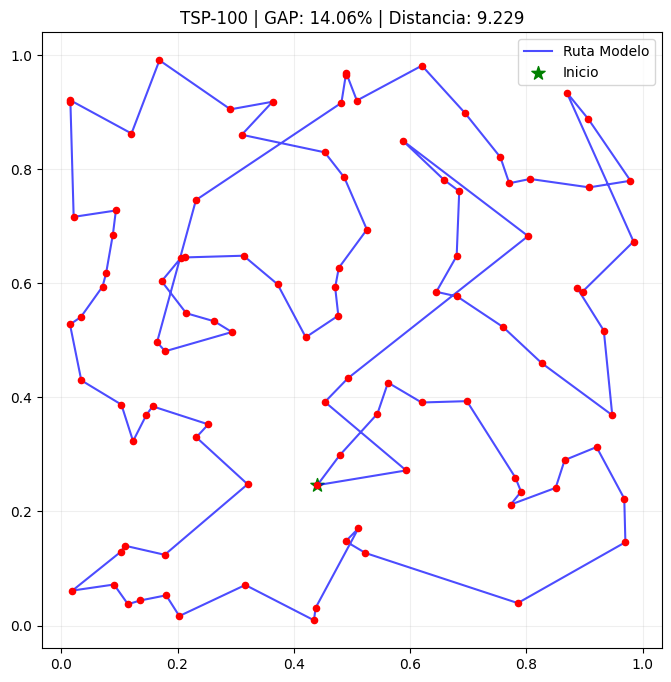

👀 Diagnóstico Visual: Si ves líneas que se cruzan en forma de 'X', eso es lo que nos cuesta el 10%.


In [ ]:
#PLOTEO DE UNA RUTA DIFICIL
def plot_hard_example(model, val_loader, device):
    """
    Toma un lote, aplica TTA y dibuja la mejor ruta encontrada.
    """
    model.eval()
    
    # Tomamos solo el primer lote
    batch_x, batch_y_opt = next(iter(val_loader))
    batch_x = batch_x.to(device)
    
    # Elegimos el primer mapa del lote para dibujar
    idx_mapa = 0
    mapa_unitario = batch_x[idx_mapa:idx_mapa+1] # [1, 100, 2]
    
    # 1. Aplicamos TTA Manualmente para este mapa
    with torch.no_grad():
        # Aumentar x8
        aug_x = augment_xy_data_by_8_fold(mapa_unitario) # [8, 100, 2]
        
        # Predecir
        pred_aug = model.greedy_decode(aug_x) # [8, 100]
        
        # Calcular distancias
        lens = calculate_tour_length(aug_x, pred_aug)
        
        # Encontrar el mejor de los 8
        best_idx = lens.argmin().item()
        best_tour = pred_aug[best_idx].cpu().numpy()
        best_points = aug_x[best_idx].cpu().numpy() # Usamos los puntos rotados correspondientes
        
        # Comparar con el óptimo (si lo tenemos)
        len_model = lens[best_idx].item()
        len_opt = calculate_tour_length(mapa_unitario, batch_y_opt[idx_mapa:idx_mapa+1].to(device)).item()
        gap = (len_model - len_opt) / len_opt * 100
        
    # 2. Dibujar
    plt.figure(figsize=(8, 8))
    
    # Puntos
    x = best_points[:, 0]
    y = best_points[:, 1]
    
    # Líneas (cerramos el ciclo sumando el inicio al final)
    tour_x = list(x[best_tour]) + [x[best_tour[0]]]
    tour_y = list(y[best_tour]) + [y[best_tour[0]]]
    
    plt.plot(tour_x, tour_y, 'b-', linewidth=1.5, alpha=0.7, label='Ruta Modelo')
    plt.scatter(x, y, c='red', s=20, zorder=5)
    plt.scatter(x[best_tour[0]], y[best_tour[0]], c='green', s=100, marker='*', label='Inicio')
    
    plt.title(f"TSP-100 | GAP: {gap:.2f}% | Distancia: {len_model:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
    
    print(f"👀 Diagnóstico Visual: Si ves líneas que se cruzan en forma de 'X', eso es lo que nos cuesta el 10%.")

# Ejecutar visualización
plot_hard_example(model, val_loader_hard, DEVICE)